FISTA
==

原画像
--

Text(0.5,1,'元画像')

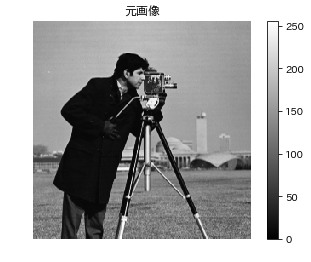

In [144]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.data import camera

im = camera().astype(np.float)[::2, ::2]
plt.imshow(im, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()
plt.title("元画像")

（非縮小）ウェーブレット変換
--

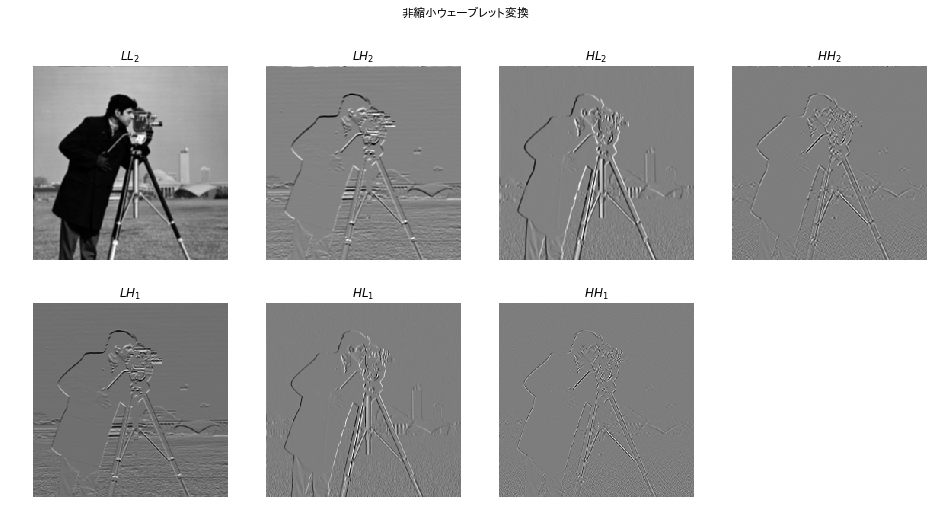

In [139]:
def horizontal(im):
    im2 = np.roll(im, 1, axis=1)
    return (im + im2) / 2., (im - im2) / 2.

def vertical(im):
    im2 = np.roll(im, 1, axis=0)
    return (im + im2) / 2., (im - im2) / 2.

def wavelet(im):
    l, h = horizontal(im)
    hl, hh = vertical(h)
    ll, lh = vertical(l)
    return ll, lh, hl, hh

def wavelet2(im):
    ll, lh, hl, hh = wavelet(im)
    ll2, lh2, hl2, hh2 = wavelet(ll)
    return np.array([ll2, lh2, hl2, hh2, lh, hl, hh])
    
coeffs = wavelet2(im)
titles = ['$LL_{2}$', '$LH_{2}$', '$HL_{2}$', '$HH_{2}$', '$LH_{1}$', '$HL_{1}$', '$HH_{1}$']
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()
for i, (coef, title) in enumerate(zip(coeffs, titles)):
    ax[i].imshow(coef, cmap='gray', interpolation='Nearest')
    ax[i].axis('off')
    ax[i].set_title(title)
ax[-1].axis('off')
plt.suptitle("非縮小ウェーブレット変換")
plt.savefig('wavelet.png', dpi=220)

ボケカーネルを得る
--

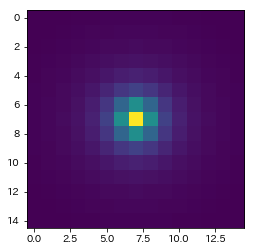

In [121]:
def get_blur_kernel():
    """ ボケカーネルを得る """
    x = np.arange(-7, 8)
    y = np.arange(-7, 8)
    xx, yy = np.meshgrid(x, y)
    return 1. / (xx ** 2 + yy ** 2 + 1)
 
h = get_blur_kernel()
h /= h.sum()
plt.imshow(h)

ノイズありボケ画像を得る
--
* $\sigma^{2} = 2$

Text(0.5,1,'ボケ画像')

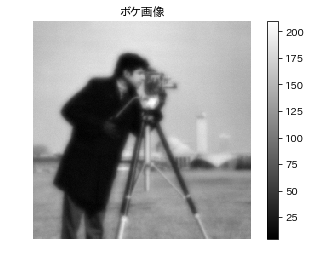

In [145]:
from scipy.signal import convolve2d

b = convolve2d(im, h, mode='same', boundary='symm') + np.random.randn(256, 256) * np.sqrt(2.)

plt.imshow(b, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()
plt.title("ボケ画像")

ISTA
--

In [102]:
from skimage.measure import compare_psnr

def ISTA(b, L=1., lam=3e-2, n_iter=170):

    x = wavelet2(b.copy())
    
    psnrs = []
    for k in range(n_iter):
        fp = convolve2d(np.sum(x, axis=0), h, mode='same', boundary='symm') 
        bp = convolve2d(fp - b, h, mode='same', boundary='symm') 
        x -= wavelet2(bp)
        shrink = np.abs(x) - lam / L
        x = shrink * (shrink > 0) * np.sign(x)
    
        psnr = compare_psnr(im / 255., np.sum(x, axis=0) / 255.)
        psnrs.append(psnr)
        
        if (k + 1) % 10 == 0:
            print(k + 1, psnr)
            
    return np.sum(x, axis=0), np.array(psnrs)

In [115]:
im_ISTA, psnrs_ISTA = ISTA(b)

10 25.7239531914
20 26.7782225674
30 27.3916926502
40 27.8038986458
50 28.1046380491
60 28.3351987326
70 28.5163269413
80 28.6608219041
90 28.7760609708
100 28.8673113025
110 28.9386769084
120 28.9937818229
130 29.0352768906
140 29.0648495031
150 29.0839811068
160 29.0942467208
170 29.0969433159


In [106]:
def FISTA(b, L=1., lam=3e-2, n_iter=30):

    x = wavelet2(b.copy())
    y = x.copy()
    t = 1.
    
    psnrs = []
    for k in range(n_iter):
        fp = convolve2d(np.sum(y, axis=0), h, mode='same', boundary='symm') 
        bp = convolve2d(fp - b, h, mode='same', boundary='symm') 
        y -= wavelet2(bp)
        shrink = np.abs(y) - lam / L
        x_new = shrink * (shrink > 0) * np.sign(y)    
        t_new = (1 + np.sqrt(1 + 4 * t * t)) / 2
        y_new = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
        y = y_new

        psnr = compare_psnr(im / 255., np.sum(x, axis=0) / 255.)
        psnrs.append(psnr)
        
        if (k + 1) % 5 == 0:
            print(k + 1, compare_psnr(im / 255., np.sum(x, axis=0) / 255.))
            
    return np.sum(x, axis=0), np.array(psnrs)

In [116]:
im_FISTA, psnrs_FISTA = FISTA(b)

5 25.1973345127
10 26.8718633829
15 27.9087012114
20 28.5585004848
25 28.9567995736
30 29.123405503


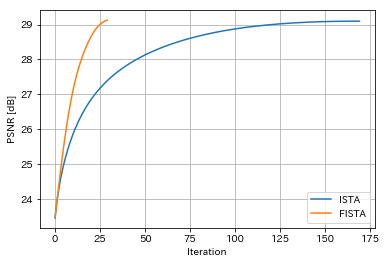

In [117]:
plt.plot(psnrs_ISTA, label="ISTA")
plt.plot(psnrs_FISTA, label="FISTA")
plt.legend()
plt.grid()
plt.ylabel("PSNR [dB]")
plt.xlabel("Iteration")
plt.savefig("PSNR_vs_iteration.png", dpi=300)

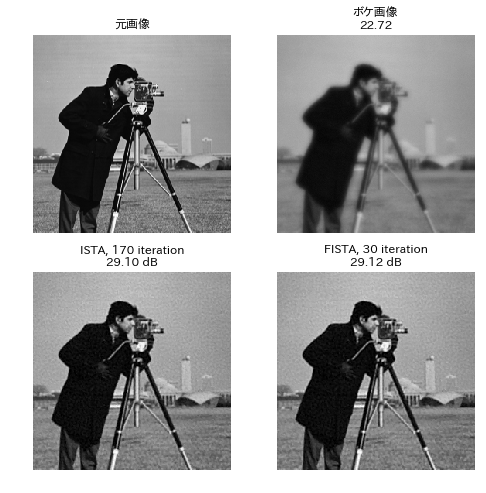

In [148]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
ax[1].imshow(b, cmap='gray', interpolation='Nearest',  vmin=0, vmax=255)
ax[2].imshow(im_ISTA, cmap='gray', interpolation='Nearest',  vmin=0, vmax=255)
ax[3].imshow(im_FISTA, cmap='gray', interpolation='Nearest',  vmin=0, vmax=255)

ax[0].set_title("元画像")
ax[1].set_title("ボケ画像\n{:.2f}".format(compare_psnr(im / 255, b / 255)))
ax[2].set_title("ISTA, 170 iteration\n{:.2f} dB".format(psnrs_ISTA[-1]))
ax[3].set_title("FISTA, 30 iteration\n{:.2f} dB".format(psnrs_FISTA[-1]))

for a in ax:
    a.axis('off')
    
plt.savefig("images.png", dpi=220)